# Experiment: Style Translation with a Generative Adversarial Network
After we have shown that it is possible to learn 3D LUTs with a CNN in the previous experiment we want to learn the style translation between images of different analog films with 3D LUTs. In the first attempt of this style translation, we are going to use a generative adversarial network (GAN) as in FilmGAN (https://www.researchgate.net/publication/376411929_Film-GAN_towards_realistic_analog_film_photo_generation). 
Generative adversarial networks were introduced in 2014 as a new framework that simultaneously trains two models, a generator and a discriminator. The generator attempts to "maximize the probability of the discriminator making a mistake", while the discriminator attempts to estimate the "probability that a sample came from the training data rather than from the generator". In training, the discriminator and the generator compete with each other, they are adversaries and ideally improve each other until the data generated by the generator is indistinguishable from the training data. 

Source: https://arxiv.org/pdf/1406.2661

In this experiment we are going to reuse the ResNet based LUT generator CNN as the generator and use the discriminator proposed in the Pytorch DCGAN tutorial as the discriminator (https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html). We are going to train the network on paired images as in the previous experiment to test if it is generally capable of generating 3D LUTs and then train the network on unpaired data to see if it can perform the style translation between different analog films. 

As many parts of this experiment are identical to the previous experiment we do not explain them in detail in this notebook. Please refer to the previous notebooks for further information.

# Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
from torchvision import transforms
from tqdm import tqdm
from PIL import Image
from IPython.display import display
import os
import matplotlib.pyplot as plt
from pytorch_msssim import ssim, ms_ssim # https://pypi.org/project/pytorch-msssim/
import torchvision.transforms.functional as TF
from torchinfo import summary
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Hyperparameters

In [2]:
batch_size = 8
learning_rate = 1e-3
beta1 = 0.5
num_epochs = 1000

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of feature maps in discriminator
ndf = 64

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset

In [4]:
class PairedImageDataset(Dataset):
    def __init__(self, ungraded_images, graded_images, transform=None):
        self.ungraded_images = ungraded_images
        self.graded_images = graded_images
        self.transform = transform

    def __len__(self):
        return len(self.ungraded_images)

    def __getitem__(self, idx):
        ungraded = self.ungraded_images[idx]
        graded = self.graded_images[idx]
        if self.transform:
            ungraded = self.transform(ungraded)
            graded = self.transform(graded)
        return ungraded, graded

In [5]:
transform64 = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

In [6]:
transform256 = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

In [7]:
def load_images_from_directory(directory_path, num_images=100):
    images = []
    files = os.listdir(directory_path)
    # Ensure only images are processed
    image_files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    for i, image_file in enumerate(image_files[:num_images]):
        image_path = os.path.join(directory_path, image_file)
        img = Image.open(image_path).convert('RGB')  # Convert to RGB in case of grayscale
        img = transform64(img)  # Apply the transformations
        images.append(img)
        
    images_tensor = torch.stack(images)
    images_tensor = images_tensor.permute(0, 2, 3, 1)
    return images_tensor

ungraded_images = load_images_from_directory('../../analogdb_images_scaled/kodak_ektar', num_images=300)
graded_images = load_images_from_directory('../../analogdb_images_scaled/kodak_ultramax/BW', num_images=300)

# Verify the shape of the tensors
print(ungraded_images.shape)  # Should be [100, 64, 64, 3]
print(graded_images.shape)    # Should be [100, 64, 64, 3]

torch.Size([300, 64, 64, 3])
torch.Size([300, 64, 64, 3])


# Generator
The model used for this experiment is based on the Residual Network (ResNet) architecture proposed in the paper `Deep Residual Learning for Image Recognition`: https://arxiv.org/pdf/1512.03385

In [8]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(residual)
        return F.relu(out)

In [9]:
class ResNetLUTGenerator(nn.Module):
    def __init__(self, lut_size=8, trilinear=True, input_channels=3):
        super(ResNetLUTGenerator, self).__init__()
        self.lut_size = lut_size
        self.trilinear = trilinear
        
        # Initial convolution
        self.initial_conv = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        
        # ResNet feature extraction
        self.layer1 = self._make_layer(32, 64, stride=2)
        self.layer2 = self._make_layer(64, 128, stride=2)
        self.layer3 = self._make_layer(128, 256, stride=2)
        
        # Global average pooling
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        
        # LUT generator
        self.lut_generator = nn.Sequential(
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, lut_size * lut_size * lut_size * 3)
        )

    def _make_layer(self, in_channels, out_channels, stride):
        return ResidualBlock(in_channels, out_channels, stride)


    def _trilinear_interpolation(self, luts, images):
        # Scale images to be between -1 and 1
        img = (images - 0.5) * 2.0  # Shape: [4, 3, 256, 256]
    
        # Add a singleton dimension to represent "channel" for LUT interpolation
        img = img.permute(0, 2, 3, 1).unsqueeze(1)  # Shape: [4, 1, 256, 256, 3]
    
        # Ensure LUT is in the correct format
        LUT = luts.permute(0, 4, 1, 2, 3)  # Shape: [4, 3, 8, 8, 8]
    
        # Perform grid sampling for each channel
        result = F.grid_sample(LUT, img, mode='bilinear', padding_mode='border', align_corners=False)  # [4, 3, 1, 256, 256]
    
        # Remove the singleton dimension and permute to the correct format
        result = result.squeeze(2)  # Remove the extra "depth" dimension: [4, 3, 256, 256]
    
        return result

    def _simple_approach(self, luts, images):
        lut = luts.view(luts.shape[0], luts.shape[2], luts.shape[2], luts.shape[2], 3)
        image_normalized = (images * luts.shape[2]-1).long()
        image_normalized = torch.clamp(image_normalized, 0, luts.shape[2]-1)
            
        r = image_normalized[:, 0, :, :]
        g = image_normalized[:, 1, :, :]
        b = image_normalized[:, 2, :, :]
            
        transformed = lut[torch.arange(luts.shape[0]).unsqueeze(-1).unsqueeze(-1), r, g, b]
        transformed = transformed.permute(0, 3, 1, 2)

        return transformed


    def forward(self, x):
        # Feature extraction
        x_orig = x  # Store original input
        x = self.initial_conv(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        
        # Global pooling and feature compression
        features = self.global_pool(x).view(x.size(0), -1)
        
        # Generate LUT
        lut = self.lut_generator(features)
        lut = lut.view(-1, self.lut_size, self.lut_size, self.lut_size, 3)
        lut = torch.sigmoid(lut)
        
        # Apply LUT to original input
        if self.trilinear:
            transformed = self._trilinear_interpolation(lut, x_orig)
        else:
            transformed = self._simple_approach(lut, x_orig)
        return transformed, lut

# Discriminator CNN
The discriminator (D) "takes a 3x64x64 input image, processes it through a series of Conv2d, BatchNorm2d, and LeakyReLU layers, and outputs the final probability through a Sigmoid activation function. This architecture can be extended with more layers if necessary for the problem, but there is significance to the use of the strided convolution, BatchNorm, and LeakyReLUs. The DCGAN paper mentions it is a good practice to use strided convolution rather than pooling to downsample because it lets the network learn its own pooling function. Also batch norm and leaky relu functions promote healthy gradient flow which is critical for the learning process of both generator (G) and D."

Source: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

In [10]:
class DiscriminatorCNN(nn.Module):
    def __init__(self):
        super(DiscriminatorCNN, self).__init__()
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1, 1)

In [11]:
test_model = DiscriminatorCNN()
summary(test_model, input_size=(32, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
DiscriminatorCNN                         [32, 1]                   --
├─Sequential: 1-1                        [32, 1, 1, 1]             --
│    └─Conv2d: 2-1                       [32, 64, 32, 32]          3,072
│    └─LeakyReLU: 2-2                    [32, 64, 32, 32]          --
│    └─Conv2d: 2-3                       [32, 128, 16, 16]         131,072
│    └─BatchNorm2d: 2-4                  [32, 128, 16, 16]         256
│    └─LeakyReLU: 2-5                    [32, 128, 16, 16]         --
│    └─Conv2d: 2-6                       [32, 256, 8, 8]           524,288
│    └─BatchNorm2d: 2-7                  [32, 256, 8, 8]           512
│    └─LeakyReLU: 2-8                    [32, 256, 8, 8]           --
│    └─Conv2d: 2-9                       [32, 512, 4, 4]           2,097,152
│    └─BatchNorm2d: 2-10                 [32, 512, 4, 4]           1,024
│    └─LeakyReLU: 2-11                   [32, 512, 4, 4]    

# Train Functions

In [12]:
def display_image(image):
    tensor_image = image.detach().cpu()
    # Rearrange to HWC format and scale to [0, 255]
    image_np = np.transpose(tensor_image.numpy(), (1, 2, 0))  # Select the first image in batch and permute to HWC
    image_np = (image_np * 255).clip(0, 255).astype(np.uint8)
            
    image = Image.fromarray(image_np)
    display(image)

In [13]:
def display_images(images, titles=None):
    # Three subplots in one row
    fig, axes = plt.subplots(1, 3, figsize=(4, 2))
    
    # Convert and display each image
    for idx, (ax, img) in enumerate(zip(axes, [images[0], images[1], images[2]])):
        # Convert tensor to numpy array
        tensor_image = img.detach().cpu()
        image_np = np.transpose(tensor_image.numpy(), (1, 2, 0))
        image_np = (image_np * 255).clip(0, 255).astype(np.uint8)
        
        # Display the image
        ax.imshow(image_np)
        ax.axis('off')
        
        # Set title if provided
        if titles and idx < len(titles):
            ax.set_title(titles[idx])
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

### Pretraining

In [17]:
def pretrain_gen(generator, dataloader, optimizer_G, num_epochs=10, device='cuda'):
    print("Pretraining Generator...")
    losses_G = []
    for epoch in tqdm(range(num_epochs)):
        running_loss_G = 0.0
        for ungraded, _ in dataloader:
            ungraded = ungraded.to(device)

            optimizer_G.zero_grad()

            fake_images, luts = generator(ungraded)

            # Reconstruction loss: Ensure fake_images look like ungraded
            reconstruction_loss_fn = torch.nn.L1Loss()
            reconstruction_loss = reconstruction_loss_fn(fake_images, ungraded)

            reconstruction_loss.backward()
            optimizer_G.step()

            running_loss_G += reconstruction_loss.item()
            losses_G.append(running_loss_G / len(dataloader))

    print("Original Image:")
    display_image(ungraded[0])
    print("Fake Image after Pretraining:")
    display_image(fake_images[0])
    plot_loss([losses_G], ["Generator loss"])

In [18]:
def pretrain_disc(discriminator, dataloader, optimizer_D, num_epochs=10, device="cuda"):
    # -------------------------
    # Pretrain Discriminator
    # -------------------------
    print("Pretraining Discriminator...")
    running_loss_D = 0.0
    losses_D = []
    criterion = nn.BCELoss()
    for epoch in tqdm(range(num_epochs)):
        for ungraded, graded in dataloader:
            ungraded, graded = ungraded.to(device), graded.to(device)

            batch_size = ungraded.size(0)
            fake_images = graded  # Use graded images as fake for pretraining
            real_labels = torch.ones(batch_size, 1).to(device)
            fake_labels = torch.zeros(batch_size, 1).to(device)

            optimizer_D.zero_grad()
            # Discriminator on real images
            outputs_real = discriminator(ungraded)
            d_loss_real = criterion(outputs_real, real_labels)

            # Discriminator on fake images
            outputs_fake = discriminator(fake_images)
            d_loss_fake = criterion(outputs_fake, fake_labels)

            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            optimizer_D.step()

            running_loss_D += d_loss.item()
            losses_D.append(d_loss.item())

        #print(f"Epoch {epoch + 1}/{num_epochs}, Discriminator Loss: {running_loss_D / len(dataloader):.4f}")
    print(f"Discriminator Loss: {running_loss_D / len(dataloader):.4f}")
    plot_loss([losses_D], ["Discriminator loss"])

In [19]:
def compute_gradient_penalty(discriminator, real_samples, fake_samples, device='cuda'):
    # Random weight term for interpolation between real and fake samples
    alpha = torch.rand(real_samples.size(0), 1, 1, 1).to(device)
    interpolated_samples = alpha * real_samples + (1 - alpha) * fake_samples
    interpolated_samples.requires_grad_(True)

    # Calculate discriminator output for interpolated samples
    d_interpolated = discriminator(interpolated_samples)
    grad_outputs = torch.ones_like(d_interpolated).to(device)
    
    # Compute the gradients w.r.t. the interpolated samples
    gradients = torch.autograd.grad(outputs=d_interpolated, inputs=interpolated_samples, grad_outputs=grad_outputs, create_graph=True, retain_graph=True, only_inputs=True)[0]
    
    # Compute the gradient penalty
    gradient_penalty = ((gradients.view(gradients.size(0), -1).norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [20]:
def calc_disc_loss(discriminator, graded, fake_images, real_labels, fake_labels, gradient_penalty=False):
    if gradient_penalty:
        outputs_real = discriminator(graded)
        outputs_fake = discriminator(fake_images.detach())
            
        gradient_penalty = compute_gradient_penalty(discriminator, graded, fake_images.detach(), device)
        d_loss = -outputs_real.mean() + outputs_fake.mean() + 10 * gradient_penalty
        return d_loss
    else:
        # Discriminator on real images
        criterion = nn.BCELoss()
        outputs_real = discriminator(graded)
        d_loss_real = criterion(outputs_real, real_labels)
    
        # Discriminator on fake images
        outputs_fake = discriminator(fake_images)
        d_loss_fake = criterion(outputs_fake, fake_labels)
    
        d_loss = d_loss_real + d_loss_fake
        return d_loss

In [1]:
def train_gan(generator, discriminator, dataloader, optimizer_G, optimizer_D, criterion, num_epochs=10, device='cuda', gradient_penalty=False):
    """
    Train the GAN with both generator and discriminator.

    Parameters:
    - generator: The generator model (your LUT generator).
    - discriminator: The discriminator model.
    - dataloader: Dataloader for the real images (graded images).
    - optimizer_G: Optimizer for the generator.
    - optimizer_D: Optimizer for the discriminator.
    - criterion: Loss function (usually BCELoss).
    - num_epochs: Number of epochs to train.
    - device: Device to run the models on ('cuda' or 'cpu').
    """
    
    # Ensure the models are in training mode
    generator.train()
    discriminator.train()

    losses_G = []
    losses_D = []
    losses_H = []

    #schedulerD = optim.lr_scheduler.StepLR(optimizer_G, step_size=200, gamma=0.2)
    #schedulerG = ReduceLROnPlateau(optimizer_G, mode='min', factor=0.1, patience=10)
    schedulerG = optim.lr_scheduler.StepLR(optimizer_G, step_size=50, gamma=0.1)

    for epoch in tqdm(range(num_epochs)):
        running_loss_D = 0.0
        running_loss_G = 0.0
        running_loss_Hist = 0.0
        for i, (ungraded, graded) in enumerate(dataloader):
            ungraded, graded = ungraded.to(device), graded.to(device)

            batch_size = ungraded.size(0)
            # Real and fake labels (for BCE loss)
            real_labels = torch.ones(batch_size, 1).to(device)
            fake_labels = torch.zeros(batch_size, 1).to(device)
            
            # Train Discriminator
            optimizer_D.zero_grad()
            # Generate fake images
            with torch.no_grad():
                fake_images, luts = generator(ungraded)
            
            d_loss = calc_disc_loss(discriminator, graded, fake_images.detach(), real_labels, fake_labels, gradient_penalty)
            
            d_loss.backward()
            optimizer_D.step()

            # Train Generator

            # Generator wants the discriminator to classify its fake images as real
            optimizer_G.zero_grad()
            # Create fake images (generated)
            fake_images, luts = generator(ungraded)
            
            outputs_fake_gen = discriminator(fake_images)
            
            # Adversarial loss
            #g_adv_loss = -discriminator(fake_images).mean()
            outputs_fake_gen = discriminator(fake_images)
            g_adv_loss = criterion(outputs_fake_gen, real_labels)
            
            # Combine losses with appropriate weights
            g_loss_total = (
                g_adv_loss * 1
            )
            
            g_loss_total.backward()
            optimizer_G.step()

            # Track running losses
            running_loss_D += d_loss.item()
            running_loss_G += g_adv_loss.item()
            running_loss_Hist += style_loss.item()

        avg_epoch_lossG = running_loss_G / len(dataloader)
        avg_epoch_lossD = running_loss_D / len(dataloader)
        #schedulerG.step(avg_epoch_lossG)
        #schedulerD.step(avg_epoch_lossD)
        schedulerG.step()
        #schedulerD.step()
            
        
        losses_G.append(avg_epoch_lossG)
        losses_D.append(avg_epoch_lossD)
        losses_H.append(running_loss_Hist / len(dataloader))

        if epoch % 50 == 0:
            display_images([graded[0], ungraded[0], fake_images[0]], ["graded", "ungraded", "fake"])
            display_images([graded[int(batch_size/4)], ungraded[int(batch_size/4)], fake_images[int(batch_size/4)]], ["graded", "ungraded", "fake"])
            display_images([graded[int(batch_size/2)], ungraded[int(batch_size/2)], fake_images[int(batch_size/2)]], ["graded", "ungraded", "fake"])
        # Print the average loss for the epoch
        #print(f"Epoch [{epoch + 1}/{num_epochs}], D Loss: {running_loss_D / len(dataloader):.4f}, G Loss: {running_loss_G / len(dataloader):.4f}")
    plot_losses(losses_G, losses_H)

In [22]:
def plot_loss(loss, title):
    """Plot losses"""
    plt.figure(figsize=(10, 5))
    losses = ""
    for index,l in enumerate(loss):
        plt.plot(l, label=title[index], color='blue')
        losses += title[index] + " "
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title(f"Training Losses: {losses}")
    plt.grid(True)
    plt.show()

In [23]:
def plot_losses(losses_G, losses_D):
    """Plot the generator and discriminator losses"""
    plt.figure(figsize=(10, 5))
    plt.plot(losses_G, label="Generator Loss", color='blue')
    plt.plot(losses_D, label="Discriminator Loss", color='red')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training Losses (Generator and Discriminator)")
    plt.grid(True)
    plt.show()

In [24]:
transform = transforms.Compose([transforms.ToTensor()])

In [25]:
ungraded_images_np = ungraded_images.numpy()
graded_images_np = graded_images.numpy()

dataset = PairedImageDataset(ungraded_images_np, graded_images_np, transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Training
Ahead of the training, we pretrain both the discriminator and the generator. As shown in https://arxiv.org/pdf/2202.08937, pretraining is a common practice to improve GAN training. At first, we pretrain the generator for 100 episodes with a batch size of 64 and the learning rate set to 0.001. The generator gets the ungraded RGB images and is supposed to learn a so-called identity LUT - a LUT that outputs the images just as they are, as a starting point for training. Therefore, we use the mean absolute error (L1 loss) between the generated images and the input images.

In the next step, we pretrain the discriminator for 30 episodes with the same batch size and learning rate, to differentiate between the original images and the black and white images. As in https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html we use the binary cross entropy (BCE) loss function.

In [26]:
gen = ResNetLUTGenerator(lut_size=33, trilinear=True).to(device)
disc = DiscriminatorCNN().to(device)
optimizer_G = optim.Adam(gen.parameters(), lr=learning_rate, betas=(beta1, 0.999))
optimizer_D = optim.Adam(disc.parameters(), lr=learning_rate, betas=(beta1, 0.999))
criterion = nn.BCELoss()

Pretraining Generator...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:52<00:00,  1.91it/s]

Original Image:


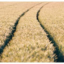

Fake Image after Pretraining:


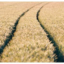

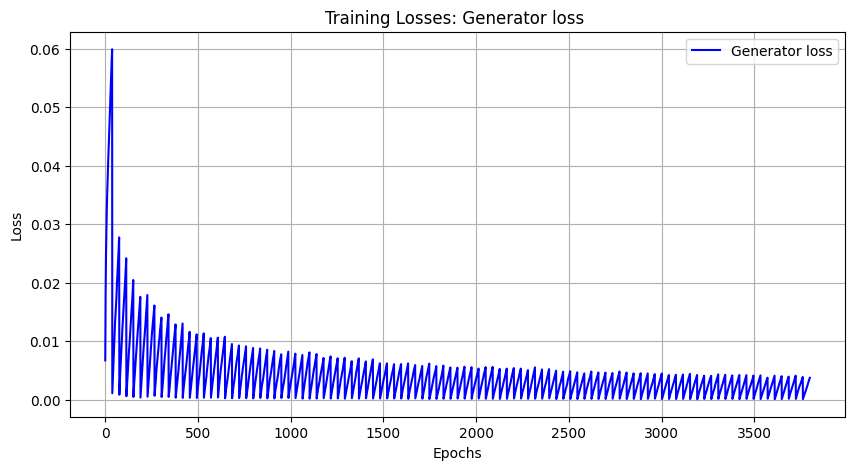

In [27]:
pretrain_gen(generator=gen, dataloader=dataloader, optimizer_G=optimizer_G, num_epochs=100, device=device)

As we can see above the generator learns to replicate the input image / an identity LUT through pretraining.

Pretraining Discriminator...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.56it/s]

Discriminator Loss: 1.4794


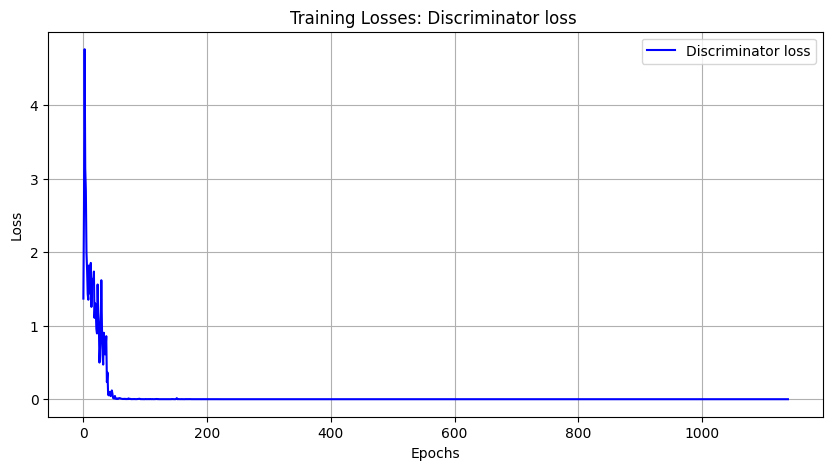

In [28]:
pretrain_disc(discriminator=disc, dataloader=dataloader, optimizer_D=optimizer_D, num_epochs=30, device=device)

As we can see above the discriminator learns to differentiate between RGB and black and white images through pretraining. Both models are now at a presumably healthy starting point for training.

  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

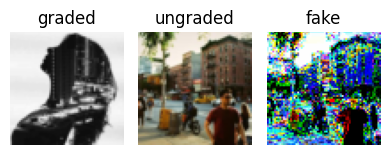

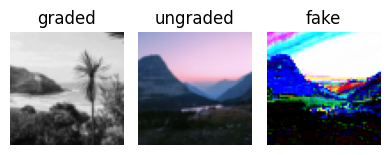

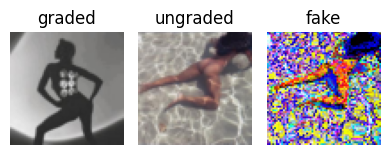

  5%|████                                                                            | 50/1000 [00:52<17:03,  1.08s/it]

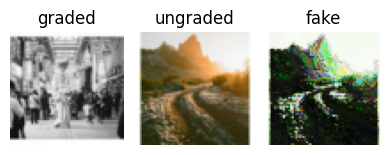

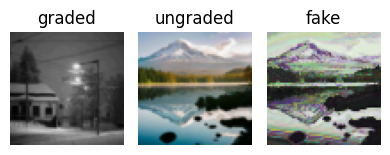

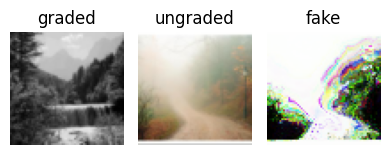

 10%|███████▉                                                                       | 100/1000 [01:44<15:14,  1.02s/it]

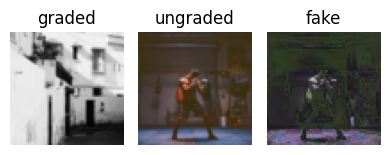

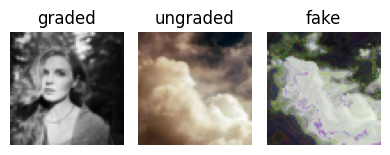

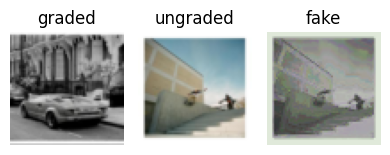

 15%|███████████▊                                                                   | 150/1000 [02:35<15:13,  1.08s/it]

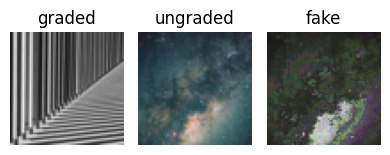

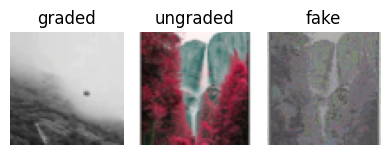

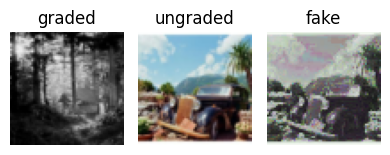

 20%|███████████████▊                                                               | 200/1000 [03:28<13:45,  1.03s/it]

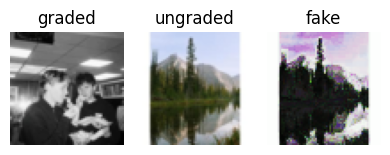

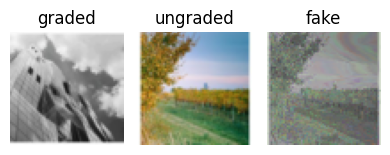

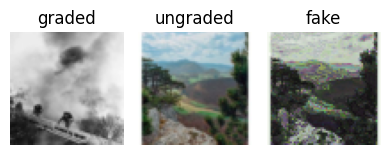

 25%|███████████████████▊                                                           | 250/1000 [04:18<12:24,  1.01it/s]

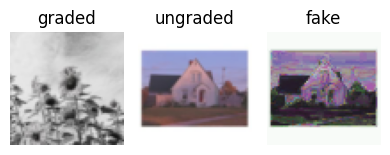

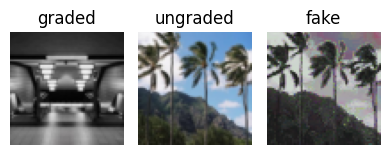

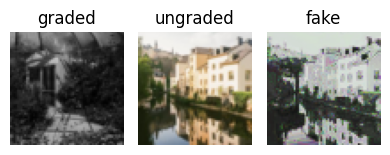

 30%|███████████████████████▋                                                       | 300/1000 [05:09<11:42,  1.00s/it]

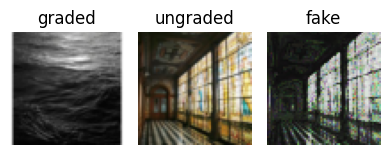

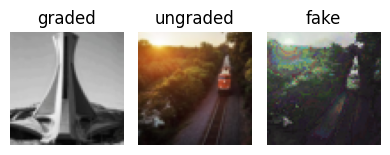

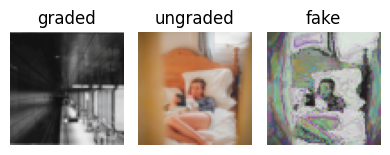

 35%|███████████████████████████▋                                                   | 350/1000 [06:00<10:52,  1.00s/it]

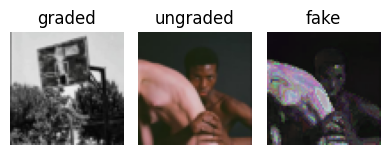

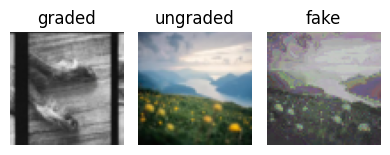

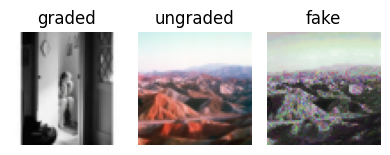

 40%|███████████████████████████████▌                                               | 400/1000 [06:50<10:05,  1.01s/it]

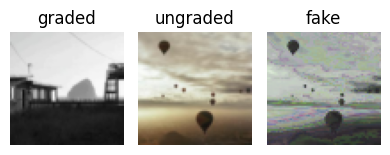

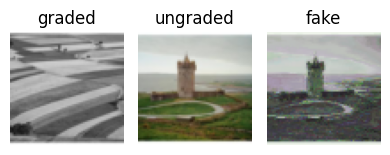

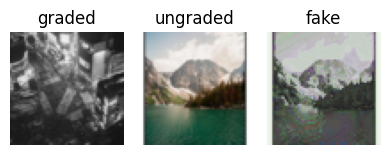

 45%|███████████████████████████████████▌                                           | 450/1000 [07:40<08:59,  1.02it/s]

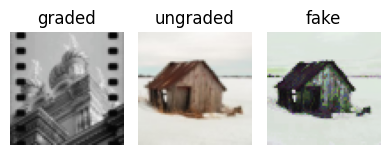

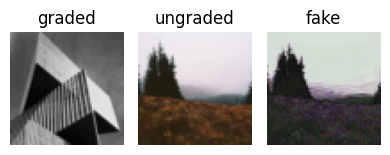

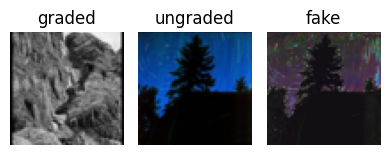

 50%|███████████████████████████████████████▌                                       | 500/1000 [08:30<08:18,  1.00it/s]

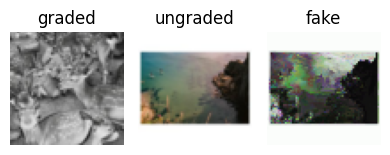

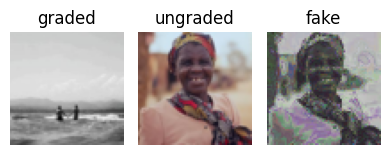

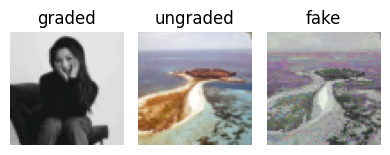

 55%|███████████████████████████████████████████▍                                   | 550/1000 [09:21<07:41,  1.03s/it]

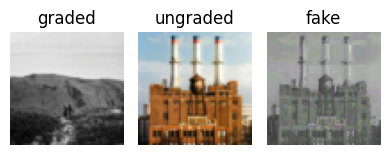

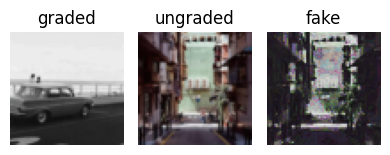

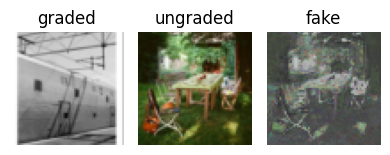

 60%|███████████████████████████████████████████████▍                               | 600/1000 [10:11<06:36,  1.01it/s]

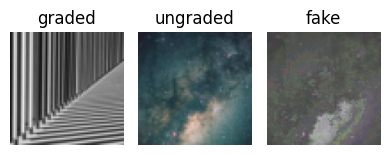

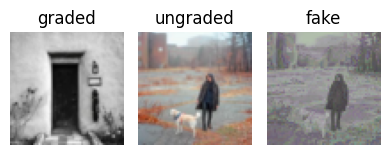

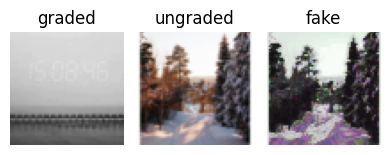

 65%|███████████████████████████████████████████████████▎                           | 650/1000 [11:02<05:53,  1.01s/it]

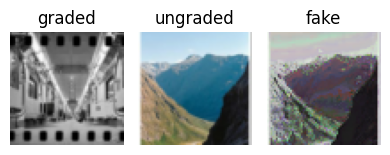

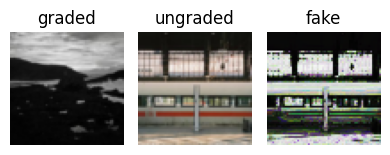

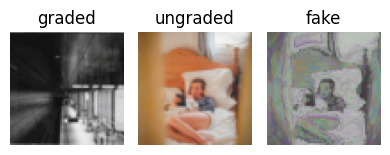

 70%|███████████████████████████████████████████████████████▎                       | 700/1000 [11:52<04:58,  1.00it/s]

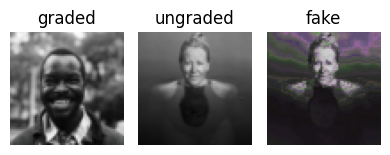

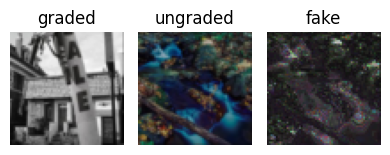

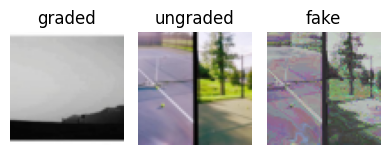

 75%|███████████████████████████████████████████████████████████▎                   | 750/1000 [12:43<04:13,  1.01s/it]

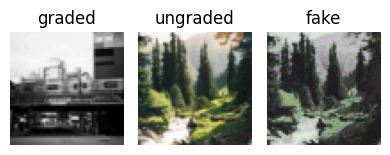

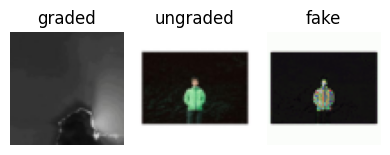

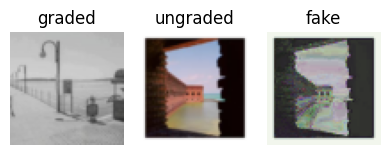

 80%|███████████████████████████████████████████████████████████████▏               | 800/1000 [13:34<03:29,  1.05s/it]

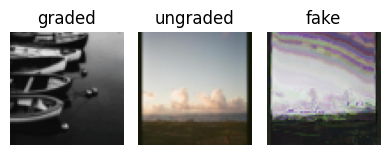

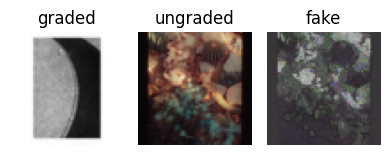

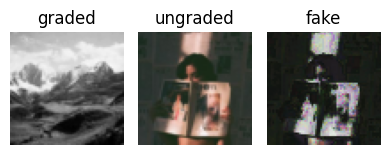

 85%|███████████████████████████████████████████████████████████████████▏           | 850/1000 [14:25<02:31,  1.01s/it]

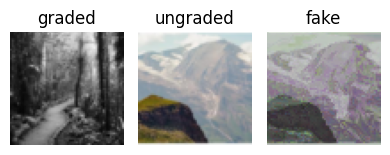

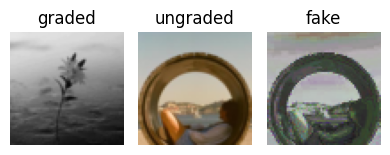

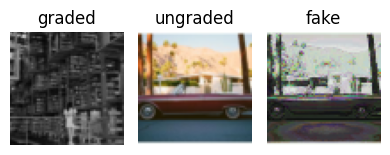

 90%|███████████████████████████████████████████████████████████████████████        | 900/1000 [15:16<01:40,  1.00s/it]

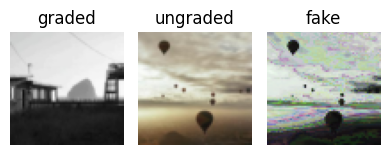

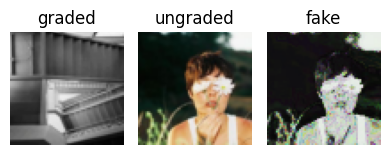

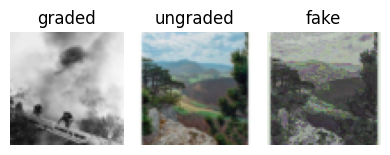

 95%|███████████████████████████████████████████████████████████████████████████    | 950/1000 [16:08<00:51,  1.03s/it]

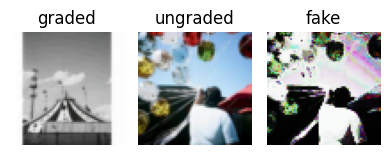

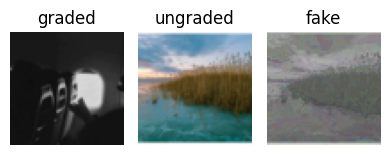

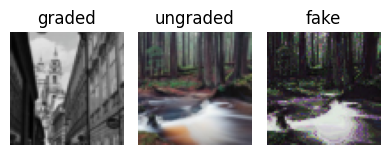

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [16:58<00:00,  1.02s/it]


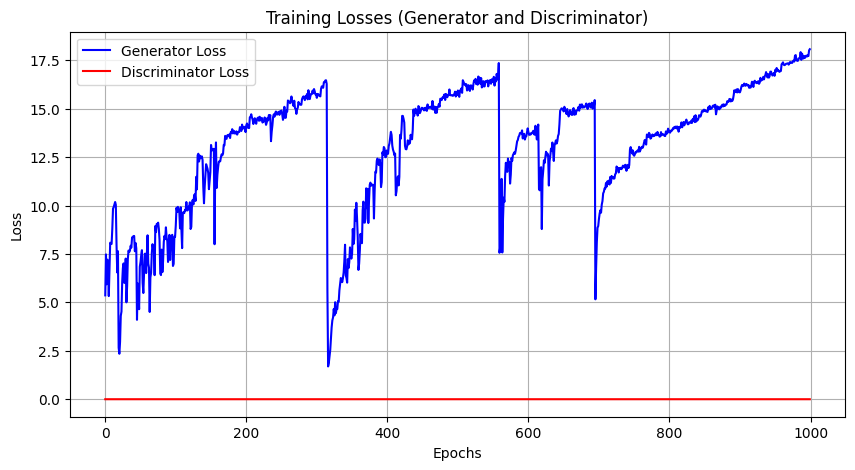

In [29]:
train_gan(generator=gen, discriminator=disc, dataloader=dataloader, optimizer_G=optimizer_G, optimizer_D=optimizer_D, criterion=criterion, num_epochs=num_epochs, device=device, gradient_penalty=False)

As we can see above the generator struggles to reproduce black and white images with unpaired training data without any artifacts or noise. We will perform further evaluation in the Notebook `01_Val_GAN_BW_Models`.

## Save Model for evaluation

In [30]:
def save_checkpoint(model, optimizer, directory, filename="models/checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    directory = f"models/{directory}"
    # Create the directory if it doesn't exist
    if not os.path.exists(directory):
        os.makedirs(directory)
        
    torch.save(checkpoint, os.path.join(directory, filename))

In [32]:
save_checkpoint(gen, optimizer_G, directory="gan_bw_lut", filename="gen_bw.pth.tar")

=> Saving checkpoint
